Problems:



In [50]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import numpy as np
import os

**Device Configuration**

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


**HyperParameters**

In [67]:
num_epochs=180 #Number of Epochs
lr=0.1  #Initial Learning Rate
batch_size=64 #Batch Size
N=4 #Number of Residual Layers
B = [2,2,2,2] #B[i] - Residual blocks in Residual layer i.Each Residual Block contains 2 Convolution layers
C = [32,64,128,256] # C[i] - Channels in Residual layer i
F = [3,3,3,3] # Conv. Kernel size in Residual layer i.
K = [1,1,1,1] #Skip connection kernel size in Residual Layer i
P = 4 # Average pool kernel size








**CIFAR 10 Dataset:**

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

**Image Preprocessing**

4 pixels are padded on each side, and a 32×32 crop is randomly sampled from the padded image or its horizontal flip. For testing, we only evaluate the single view of the original 32×32 image.

In [53]:
transform = transforms.Compose([transforms.Pad(4),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomCrop(32),
                                transforms.ToTensor()])

**CIFAR 10 DataSet Download**

In [54]:
trainingdata = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform) 
testdata = torchvision.datasets.CIFAR10(root='./data',  train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


TrainingData: 50000 images<br>
ValidationData:7500 images<br>
TestData:2500 Images<br>

In [55]:
print(len(trainingdata))
print(len(testdata))
valdata,testdata = torch.utils.data.random_split(testdata, [7500, 2500])
print(len(valdata))
print(len(testdata))

50000
10000
7500
2500


**DataLoader**

In [56]:
train_loader = torch.utils.data.DataLoader(dataset=trainingdata,
                                           batch_size=batch_size, 
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=valdata,
                                          batch_size=batch_size, 
                                          shuffle=False)
test_loader=torch.utils.data.DataLoader(dataset=testdata,
                                        batch_size=batch_size,
                                        shuffle=False)

In [57]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

for images, labels in val_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

for images, labels in test_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

782
118
40
Image batch dimensions: torch.Size([64, 3, 32, 32])
Image label dimensions: torch.Size([64])
Class labels of 10 examples: tensor([1, 4, 8, 6, 1, 0, 5, 8, 2, 1])
Image batch dimensions: torch.Size([64, 3, 32, 32])
Image label dimensions: torch.Size([64])
Class labels of 10 examples: tensor([5, 3, 2, 6, 7, 9, 3, 4, 7, 7])
Image batch dimensions: torch.Size([64, 3, 32, 32])
Image label dimensions: torch.Size([64])
Class labels of 10 examples: tensor([7, 8, 0, 3, 1, 5, 8, 1, 9, 2])


**Define the ResNet Model Class**

In [70]:
import torch.nn.functional as F
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
def project1_model():
    return ResNet(BasicBlock, [2, 2, 2, 2])


**Move the model to GPU**

In [71]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


**Check if my model is on GPU**

In [72]:
model=project1_model()

In [73]:
 print(next(model.parameters()).is_cuda) #Check if my model is on cuda

False


In [74]:

model.to(device)
print(next(model.parameters()).is_cuda)


True


**Model Summary**

In [75]:
!pip install torchsummary
from torchsummary import summary
summary(model,(3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             864
       BatchNorm2d-2           [-1, 32, 28, 28]              64
            Conv2d-3           [-1, 32, 28, 28]           9,216
       BatchNorm2d-4           [-1, 32, 28, 28]              64
            Conv2d-5           [-1, 32, 28, 28]           9,216
       BatchNorm2d-6           [-1, 32, 28, 28]              64
        BasicBlock-7           [-1, 32, 28, 28]               0
            Conv2d-8           [-1, 32, 28, 28]           9,216
       BatchNorm2d-9           [-1, 32, 28, 28]              64
           Conv2d-10           [-1, 32, 28, 28]           9,216
      BatchNorm2d-11           [-1, 32, 28, 28]              64
       BasicBlock-12           [-1, 32, 28, 28]               0
           Conv2d-13           [-1, 64, 14, 14]          18,432
      BatchNorm2d-14           [-1, 64,

In [76]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    # torch.numel() returns number of elements in a tensor

print(count_parameters(model)/1000000)

2.79761


**Define Loss Function,Optimizer and Learning Rate Scheduler**

In [77]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1,momentum=0.9,weight_decay=0.0001,nesterov=True)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[90,135],gamma=0.1)

In [78]:
def compute_accuracy(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [79]:
print("Training Model")

Training Model


In [80]:
start_time = time.time()
minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []
logging_interval=50 #Epochs
for epoch in range(num_epochs):
    model.train()
    for batch_idx,(features,targets) in enumerate(train_loader):
        #Move the input and target labels to the corresponding device
        features = features.to(device)
        targets=targets.to(device)
        #Forward propagation
        prediction=model(features)
        #Calculate Loss 
        loss=criterion(prediction,targets)
        #Set all the gradients to 0 where param.grad=True. This is done to prevent gradient accumulation 
        optimizer.zero_grad()
        #Calculate fresh Gradients of all the parameters 
        loss.backward()
        #Update all the trainable parmeters
        optimizer.step()
        #data Logging
        minibatch_loss_list.append(loss.item())
        if not batch_idx % logging_interval:
            print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                  f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                  f'| Loss: {loss:.4f}')
      

    model.eval()
    with torch.no_grad():# Saves Memory During Inference
        train_acc = compute_accuracy(model, train_loader, device=device)
        valid_acc = compute_accuracy(model, val_loader, device=device)
        print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
              f'| Train: {train_acc :.2f}% '
              f'| Validation: {valid_acc :.2f}%')
        train_acc_list.append(train_acc.item())
        valid_acc_list.append(valid_acc.item())
    
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
    
    scheduler.step()
    if epoch==0 or epoch ==50 or epoch==100 or epoch==150 or epoch==200:
      print("Learning Rate is ",lr) 

elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

test_acc = compute_accuracy(model, test_loader, device=device)
print(f'Test accuracy {test_acc :.2f}%')

    

    





        

Epoch: 001/180 | Batch 0000/0782 | Loss: 2.3597
Epoch: 001/180 | Batch 0050/0782 | Loss: 2.1153
Epoch: 001/180 | Batch 0100/0782 | Loss: 2.0332
Epoch: 001/180 | Batch 0150/0782 | Loss: 2.0169
Epoch: 001/180 | Batch 0200/0782 | Loss: 1.9674
Epoch: 001/180 | Batch 0250/0782 | Loss: 1.8462
Epoch: 001/180 | Batch 0300/0782 | Loss: 1.9353
Epoch: 001/180 | Batch 0350/0782 | Loss: 1.9175
Epoch: 001/180 | Batch 0400/0782 | Loss: 1.8803
Epoch: 001/180 | Batch 0450/0782 | Loss: 1.5742
Epoch: 001/180 | Batch 0500/0782 | Loss: 1.6599
Epoch: 001/180 | Batch 0550/0782 | Loss: 1.6489
Epoch: 001/180 | Batch 0600/0782 | Loss: 1.4257
Epoch: 001/180 | Batch 0650/0782 | Loss: 1.4046
Epoch: 001/180 | Batch 0700/0782 | Loss: 1.3606
Epoch: 001/180 | Batch 0750/0782 | Loss: 1.6030
Epoch: 001/180 | Train: 32.78% | Validation: 33.45%
Time elapsed: 0.90 min
Learning Rate is  0.1
Epoch: 002/180 | Batch 0000/0782 | Loss: 1.5668
Epoch: 002/180 | Batch 0050/0782 | Loss: 1.3354
Epoch: 002/180 | Batch 0100/0782 | Loss

In [81]:
def plot_training_loss(minibatch_loss_list, num_epochs, iter_per_epoch,
                       results_dir=None, averaging_iterations=100):

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_loss_list)),
             (minibatch_loss_list), label='Minibatch Loss')

    if len(minibatch_loss_list) > 1000:
        ax1.set_ylim([
            0, np.max(minibatch_loss_list[1000:])*1.5
            ])
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    ax1.plot(np.convolve(minibatch_loss_list,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label='Running Average')
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(results_dir, 'plot_training_loss.pdf')
        plt.savefig(image_path)




In [82]:
def plot_accuracy(train_acc_list, valid_acc_list, results_dir):

    num_epochs = len(train_acc_list)

    plt.plot(np.arange(1, num_epochs+1),
             train_acc_list, label='Training')
    plt.plot(np.arange(1, num_epochs+1),
             valid_acc_list, label='Validation')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(
            results_dir, 'plot_acc_training_validation.pdf')
        plt.savefig(image_path)

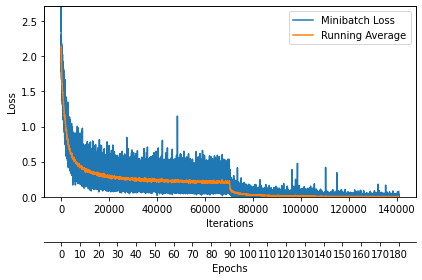

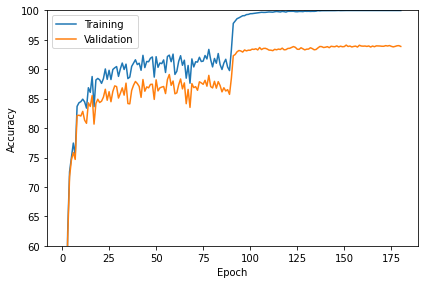

In [83]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=num_epochs,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=200)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()

In [84]:
from itertools import product
def compute_confusion_matrix(model, data_loader, device):

    all_targets, all_predictions = [], []
    with torch.no_grad():

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.to(device)
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            all_targets.extend(targets.to('cpu'))
            all_predictions.extend(predicted_labels.to('cpu'))

    all_predictions = all_predictions
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
        
    class_labels = np.unique(np.concatenate((all_targets, all_predictions)))
    if class_labels.shape[0] == 1:
        if class_labels[0] != 0:
            class_labels = np.array([0, class_labels[0]])
        else:
            class_labels = np.array([class_labels[0], 1])
    n_labels = class_labels.shape[0]
    lst = []
    z = list(zip(all_targets, all_predictions))
    for combi in product(class_labels, repeat=2):
        lst.append(z.count(combi))
    mat = np.asarray(lst)[:, None].reshape(n_labels, n_labels)
    return mat

In [85]:
def plot_confusion_matrix(conf_mat,
                          hide_spines=False,
                          hide_ticks=False,
                          figsize=None,
                          cmap=None,
                          colorbar=False,
                          show_absolute=True,
                          show_normed=False,
                          class_names=None):

    if not (show_absolute or show_normed):
        raise AssertionError('Both show_absolute and show_normed are False')
    if class_names is not None and len(class_names) != len(conf_mat):
        raise AssertionError('len(class_names) should be equal to number of'
                             'classes in the dataset')

    total_samples = conf_mat.sum(axis=1)[:, np.newaxis]
    normed_conf_mat = conf_mat.astype('float') / total_samples

    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(False)
    if cmap is None:
        cmap = plt.cm.Blues

    if figsize is None:
        figsize = (len(conf_mat)*1.25, len(conf_mat)*1.25)

    if show_normed:
        matshow = ax.matshow(normed_conf_mat, cmap=cmap)
    else:
        matshow = ax.matshow(conf_mat, cmap=cmap)

    if colorbar:
        fig.colorbar(matshow)

    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            cell_text = ""
            if show_absolute:
                cell_text += format(conf_mat[i, j], 'd')
                if show_normed:
                    cell_text += "\n" + '('
                    cell_text += format(normed_conf_mat[i, j], '.2f') + ')'
            else:
                cell_text += format(normed_conf_mat[i, j], '.2f')
            ax.text(x=j,
                    y=i,
                    s=cell_text,
                    va='center',
                    ha='center',
                    color="white" if normed_conf_mat[i, j] > 0.5 else "black")
    
    if class_names is not None:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=90)
        plt.yticks(tick_marks, class_names)
        
    if hide_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if hide_ticks:
        ax.axes.get_yaxis().set_ticks([])
        ax.axes.get_xaxis().set_ticks([])

    plt.xlabel('predicted label')
    plt.ylabel('true label')
    return fig, ax

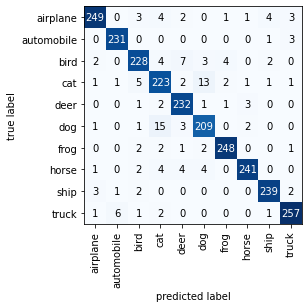

In [86]:
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

model.cpu()

mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

**Save The Model**

In [87]:
import sys
sys.path.insert(0, '/content/')
torch.save(model.state_dict(), 'saved_data/model.pt')
torch.save(optimizer.state_dict(), 'saved_data/optimizer.pt')
torch.save(scheduler.state_dict(), 'saved_data/scheduler.pt')

**Load The Model**

False
False
Test accuracy 54.72%


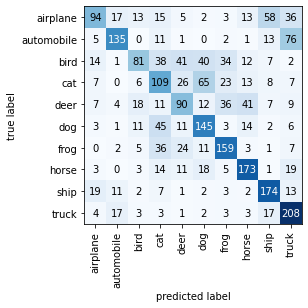

In [25]:
model = project1_model()
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}
print(next(model.parameters()).is_cuda)

model = model.cpu()
print(next(model.parameters()).is_cuda)
model.load_state_dict(torch.load('saved_data/model.pt'))
#optimizer.load_state_dict(torch.load('saved_data/optimizer.pt'))
#scheduler.load_state_dict(torch.load('saved_data/scheduler.pt'))
test_acc = compute_accuracy(model, test_loader, device=torch.device('cpu'))
print(f'Test accuracy {test_acc :.2f}%')
mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

**Show The Images**

In [88]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Parameters:
        ------------
        tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        
        Returns:
        ------------
        Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor


def show_examples(model, data_loader, unnormalizer=None, class_dict=None):
    
        
    for batch_idx, (features, targets) in enumerate(data_loader):

        with torch.no_grad():
            features = features
            targets = targets
            logits = model(features)
            predictions = torch.argmax(logits, dim=1)
        break

    fig, axes = plt.subplots(nrows=3, ncols=5,
                             sharex=True, sharey=True)
    
    if unnormalizer is not None:
        for idx in range(features.shape[0]):
            features[idx] = unnormalizer(features[idx])
    nhwc_img = np.transpose(features, axes=(0, 2, 3, 1))
    
    if nhwc_img.shape[-1] == 1:
        nhw_img = np.squeeze(nhwc_img.numpy(), axis=3)

        for idx, ax in enumerate(axes.ravel()):
            ax.imshow(nhw_img[idx], cmap='binary')
            if class_dict is not None:
                ax.title.set_text(f'P: {class_dict[predictions[idx].item()]}'
                                  f'\nT: {class_dict[targets[idx].item()]}')
            else:
                ax.title.set_text(f'P: {predictions[idx]} | T: {targets[idx]}')
            ax.axison = False

    else:

        for idx, ax in enumerate(axes.ravel()):
            ax.imshow(nhwc_img[idx])
            if class_dict is not None:
                ax.title.set_text(f'P: {class_dict[predictions[idx].item()]}'
                                  f'\nT: {class_dict[targets[idx].item()]}')
            else:
                ax.title.set_text(f'P: {predictions[idx]} | T: {targets[idx]}')
            ax.axison = False
    plt.tight_layout()
    plt.show()

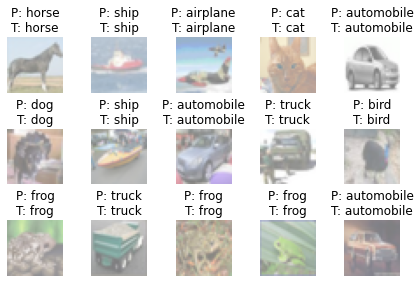

In [89]:
model.cpu()
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

show_examples(model=model, data_loader=test_loader, unnormalizer=unnormalizer,class_dict=class_dict)

**Visualising The Model**

In [31]:
!pip3 install graphviz

In [32]:
!pip install hiddenlayer

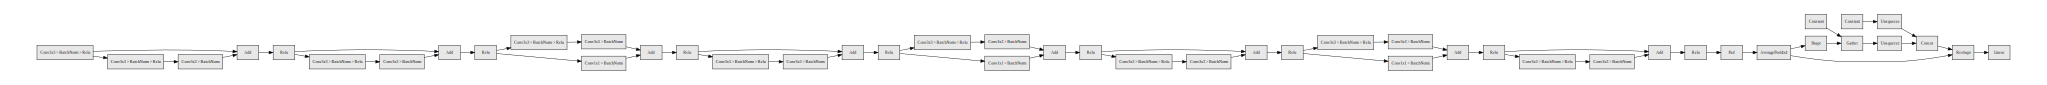

In [33]:
import hiddenlayer as hl
hl.build_graph(model, torch.zeros([64, 3, 32, 32]))

References:

1.https://pytorch-tutorial.readthedocs.io/en/latest/tutorial/chapter03_intermediate/3_2_2_cnn_resnet_cifar10/

2.https://www.cs.toronto.edu/~kriz/cifar.html

3.https://arxiv.org/pdf/1512.03385.pdf

4.https://github.com/rasbt/stat453-deep-learning-ss21/tree/main/L13/code

5.https://github.com/waleedka/hiddenlayer

